<h3>Import necessary  libs</h3>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import arff
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

<h3>Load the data</h3>

In [2]:
data = pd.read_csv('eeg+eye+state.csv')


In [3]:
data.head()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeDetection
0,4329.23,4009.23,4289.23,4148.21,4350.26,4586.15,4096.92,4641.03,4222.05,4238.46,4211.28,4280.51,4635.90,4393.85,b'0'
1,4324.62,4004.62,4293.85,4148.72,4342.05,4586.67,4097.44,4638.97,4210.77,4226.67,4207.69,4279.49,4632.82,4384.10,b'0'
2,4327.69,4006.67,4295.38,4156.41,4336.92,4583.59,4096.92,4630.26,4207.69,4222.05,4206.67,4282.05,4628.72,4389.23,b'0'
3,4328.72,4011.79,4296.41,4155.90,4343.59,4582.56,4097.44,4630.77,4217.44,4235.38,4210.77,4287.69,4632.31,4396.41,b'0'
4,4326.15,4011.79,4292.31,4151.28,4347.69,4586.67,4095.90,4627.69,4210.77,4244.10,4212.82,4288.21,4632.82,4398.46,b'0'


In [4]:
data.shape

(14980, 15)

<h3>Characteristisc of the data</h3>

In [5]:
data.describe()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4
count,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000
mean,4321.917777,4009.767694,4264.022433,4164.946326,4341.741075,4644.022379,4110.400160,4616.056904,4218.826610,4231.316200,4202.456900,4279.232774,4615.205336,4416.435832
std,2492.072174,45.941672,44.428052,5216.404632,34.738821,2924.789537,4600.926543,29.292603,2136.408523,38.050903,37.785981,41.544312,1208.369958,5891.285043
min,1030.770000,2830.770000,1040.000000,2453.330000,2089.740000,2768.210000,2086.150000,4567.180000,1357.950000,1816.410000,3273.330000,2257.950000,86.666700,1366.150000
25%,4280.510000,3990.770000,4250.260000,4108.210000,4331.790000,4611.790000,4057.950000,4604.620000,4190.770000,4220.510000,4190.260000,4267.690000,4590.770000,4342.050000
50%,4294.360000,4005.640000,4262.560000,4120.510000,4338.970000,4617.950000,4070.260000,4613.330000,4199.490000,4229.230000,4200.510000,4276.920000,4603.080000,4354.870000
75%,4311.790000,4023.080000,4270.770000,4132.310000,4347.180000,4626.670000,4083.590000,4624.100000,4209.230000,4239.490000,4211.280000,4287.180000,4617.440000,4372.820000
max,309231.000000,7804.620000,6880.510000,642564.000000,6474.360000,362564.000000,567179.000000,7264.100000,265641.000000,6674.360000,6823.080000,7002.560000,152308.000000,715897.000000


<h3>Train - Test set split</h3>

In [6]:

X = data.iloc[:, :-1]
y = data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

<h3>Scale or Standardize the data</h3>

In [7]:
# standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

<h3>k means determine k using elbow method</h3>

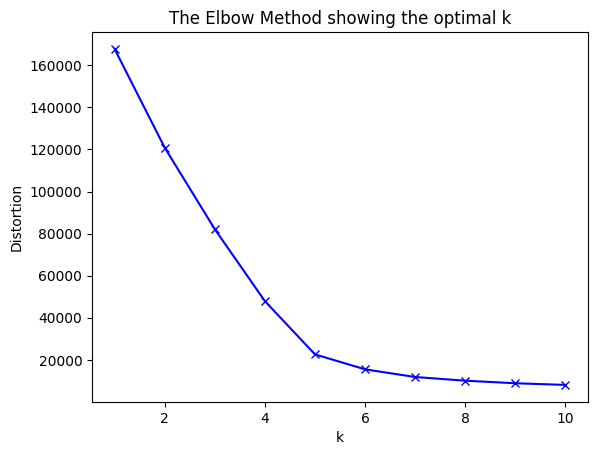

In [8]:
distortions = []
K = range(1, 11)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=123, n_init=10)
    kmeanModel.fit(X_train)
    distortions.append(kmeanModel.inertia_)

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

<h3>Define RBFN</h3>

In [9]:

class RBFN:
    def __init__(self, num_centers, sigma=1.0):
        self.num_centers = num_centers
        self.sigma = sigma
        self.centers = None
        self.weights = None

    def _rbf_kernel(self, X, centers):
        distances = cdist(X, centers)
        return np.exp(-(distances ** 2) / (2 * self.sigma ** 2))

    def fit(self, X, y, learning_rate=0.001, epochs=100):
        kmeans = KMeans(n_clusters=self.num_centers, random_state=123)
        kmeans.fit(X)
        self.centers = kmeans.cluster_centers_

        rbf_features = self._rbf_kernel(X, self.centers)

        self.weights = np.random.rand(self.num_centers)

        for epoch in range(epochs):
            for i in range(len(X)):
                rbf_features_i = rbf_features[i:i+1]

                prediction = np.dot(rbf_features_i, self.weights)

                error = y[i] - prediction
                self.weights += learning_rate * error * rbf_features_i.flatten()

    def predict(self, X):
        rbf_features = self._rbf_kernel(X, self.centers)

        predictions = np.dot(rbf_features, self.weights)
        return predictions.round()

<h3>change y_train and y_test to float</h3>

In [10]:
y_train = [float(thevalue[2]) for thevalue in y_train]
y_test = [float(thevalue[2]) for thevalue in y_test]

<h3>Determine Sigma</h3>

In [11]:
subset_size = min(500, len(X_train))

subset_indices = np.random.choice(len(X_train), size=subset_size, replace=False)
subset_data = X_train[subset_indices]

average_distance_subset = np.mean(np.linalg.norm(subset_data[:, np.newaxis] - subset_data, axis=-1))

sigma = average_distance_subset


<h3>Train the model(RBFN)</h3>

In [12]:
prefered_k = 5
rbfn = RBFN(num_centers=prefered_k, sigma=sigma)
rbfn.fit(X_train, y_train)  

/home/yosef/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<h3>Predict</h3>

In [13]:
y_pred = rbfn.predict(X_test)
accuracy_score(y_test, y_pred)

0.5310413885180241